<a id='e-summ'></a>
## Executive Summary<br>

- The best predictor (by far) of delinquency is the behaviour in the past couple of months, and in particular the last month. Banks can start using that information to plan in advance and reach out to the customer.
- The credit limit is a good indicator of financial stability. Whatever mechanism the bank is currently using works well and some of the features that go into choosing the credit line can be used directly in the model for default prediction.
- Although a gradient boosted model or a tuned random forest model might perform better, it might be worth working on a logistic regression model (especially if the model complexity can be reduced by dropping irrelevant features). A deployable model doesn't just need to be reliable, it also needs to be fast.
- The precision-recall trade-off must be discussed by business experts and the ML team to get the most benefits from the predictive modelling.
- The bank can use this model not just as a predictor but proactively to prevent default. In the process, it can be used to recommend products to customers.
- An analysis of customer lifetime value (CLV) must be done before determining whether a defaulting customer's relationship should be terminated.

# Analysing the UCI Credit Card Default Dataset and Predicting Credit Card Default

# Table of Contents

* [Problem Description](#p-desc)
* [Preparation](#prep)
    * [Importing Packages and Loading Data](#imp)
* [Exploratory Data Analysis (EDA)](#eda)
    * [Data Overview and Cleaning](#over)
    * [The Relationship Between the Variables and Default](#r-var)
    * [Correlation Between the Variables](#corr)
* [Statistical Inference](#s-inf)
    * [Is Default Affected by Gender?](#g-def)
* [Feature Engineering](#f-eng)
    * [Adding New Features](#a-feat)
    * [Encoding Categorical Data](#e-cat)
* [Machine Learning: Classification Models](#ml)
    * [Feature Selection, Scaling, Splitting and Balancing the Data](#f-sel)
    * [VIF and Deviance reduction](#vif)
    * [Logistic Regression Model](#lr)
    * [Random Forest Classifier](#rf)
    * [Gradient Boosting Classifier](#xgb)
* [Comparison of Model Performance](#comp)
* [Takeaways](#take)
    * [Future Work](#f-work)
    * [Envisioned Use Cases for CreditSesame](#u-case)
    * [Executive Summary](#e-summ)

<a id='p-desc'></a>
## Problem Description<br>

I analyse the UCI credit card default dataset available at: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#.

The dataset is details of credit card holders of an "important bank in Taiwan" for the period April to September, 2005. The features available include some basic customer demographics (gender, education, marital status and age), available credit line, their history of payment/default for the six months mentioned (Apr--Sep '05), their bill amounts and their payment amounts for that period and a binary target variable indicating default the following month.

The data was originally studied by the authors of the paper: Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

I perform some EDA to understand the data and clean the data, engineer relevant features, build predictive models to predict default and perform some statistical analyses to obtain a greater understanding of the features and their interactions. I finish with some business case scenarios where the predictive model could be applied.

### Dataset

There are 25 variables in the dataset. They are:

* **ID**: ID of each client
* **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
* **SEX**: Gender (1=male, 2=female)
* **EDUCATION**: (1=graduate school, 2=university, 3=high school, 4=others)
* **MARRIAGE**: Marital status (1=married, 2=single, 3=others)
* **AGE**: Age in years
* **PAY_0**: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
* **PAY_2**: Repayment status in August, 2005 (scale same as above)
* **PAY_3**: Repayment status in July, 2005 (scale same as above)
* **PAY_4**: Repayment status in June, 2005 (scale same as above)
* **PAY_5**: Repayment status in May, 2005 (scale same as above)
* **PAY_6**: Repayment status in April, 2005 (scale same as above)
* **BILL_AMT1**: Amount of bill statement in September, 2005 (NT dollar)
* **BILL_AMT2**: Amount of bill statement in August, 2005 (NT dollar)
* **BILL_AMT3**: Amount of bill statement in July, 2005 (NT dollar)
* **BILL_AMT4**: Amount of bill statement in June, 2005 (NT dollar)
* **BILL_AMT5**: Amount of bill statement in May, 2005 (NT dollar)
* **BILL_AMT6**: Amount of bill statement in April, 2005 (NT dollar)
* **PAY_AMT1**: Amount of payment in September, 2005 (NT dollar)
* **PAY_AMT2**: Amount of payment in August, 2005 (NT dollar)
* **PAY_AMT3**: Amount of payment in July, 2005 (NT dollar)
* **PAY_AMT4**: Amount of payment in June, 2005 (NT dollar)
* **PAY_AMT5**: Amount of payment in May, 2005 (NT dollar)
* **PAY_AMT6**: Amount of payment in April, 2005 (NT dollar)
* **default payment next month**: The target variable indicating default of payment (1=default, 0=non-default)

Some comments:

- It is not made clear as to exactly what the target indicates (default next month): it could be that the customer fails to make any payment, the customer fails to make the minimum payment or the customer fails to make the entire payment. Since there is no clarification possible, I will assume that default here indicates that the customer fails to make the minimum payment.

- The data description mentions bill statement amounts for a month and amount of payment in the same month. Usually, a bill statement for the month of May, 2005 is paid in June, 2005. I could make an informed guess by carefully looking at the amounts but I will assume that the payment in June 2005 is going towards the payment of the bill for June 2005.

- The credit limit of a person is said to include individual and family/supplemental credit. It is not clear if the bills are listed by individual or family as that could impact the data. Also, it is surprising that nobody's credit limit changed in the six month period considered but it could be a simplification introduced by the data set creator.

<a id='prep'></a>
## Preparation<br>

<a id='imp'></a>
## Importing Packages and Loading Data<br>

In [213]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.formula.api import glm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn import metrics

from sklearn.model_selection import RandomizedSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

from pprint import pprint
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [214]:
sns.set()
pd.options.display.max_columns = None

In [215]:
# Importing data
cc_df = pd.read_excel("default of credit card clients.xls", header=1)

<a id='p-desc'></a>
## Exploratory Data Analysis

<a id='over'></a>
## Date Overview and Cleaning:<br>

In [216]:
# Checking the first few rows
cc_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [217]:
# Checking for missing values
cc_df.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

There are no missing values in the dataset. That is usually good news but it's possible that some data might be corrupted; we'll check for that later.

In [218]:
# Checking the data types
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [219]:
# Simplifying column names and bringing consistency
cc_df.rename(
    columns={"PAY_0": "PAY_1", "default payment next month": "DEFAULT"}, inplace=True
)
cc_df.columns = [name.lower() for name in list(cc_df.columns)]

In [220]:
# Checking the entries of the ID column
print(cc_df["id"].value_counts())
cc_df.drop(["id"], axis=1, inplace=True)

2049     1
2708     1
8881     1
10928    1
21151    1
        ..
23841    1
21792    1
11535    1
9486     1
2047     1
Name: id, Length: 30000, dtype: int64


The `id` entries are unique for every row and seem to serve the purpose of a serial number. I will drop that variable.

In [221]:
# Checking the range of the numerical entries
cc_df.describe(
    include="all"
).transpose()  # the transpose view makes it more reader-friendly

,count,mean,std,min,25%,50%,75%,max
limit_bal,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
sex,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
education,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
marriage,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
age,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
pay_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
pay_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
pay_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
pay_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
pay_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


Even though the data description said that the minimum value of `pay_i`'s was -1, all of them have a minimum value of -2. Also `marriage` has a minimum value of 0 but the description said the minimum value is 1. And `education` has a maximum value of 6 while it was supposed to have a maximum value of 4. I'll take a closer look later.

I notice that some of the `bill_amti`'s are negative. Although surprising, it is not uncommon to have a negative balance because of merchant refunds or overpayments. The values are a bit on the higher side and I'll take another look later.

Text(0.5, 1.0, 'Distribution of defaulters vs non-defaulters')

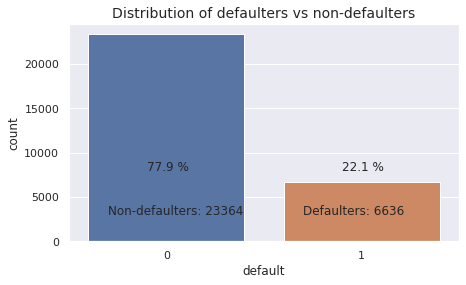

In [313]:
# The frequency of defaults
defs = cc_df["default"].sum()
non_defs = len(cc_df) - defs

# Percentage
def_perc = round(defs / len(cc_df) * 100, 1)
non_def_perc = round(non_defs / len(cc_df) * 100, 1)

# import sys
plt.figure(figsize=(7, 4))
# sns.set_context('notebook', font_scale=1.2)
sns.countplot("default", data=cc_df)  # ,palette="Blues"
plt.annotate(
    "Non-defaulters: {}".format(non_defs),
    xy=(-0.3, 15000),
    xytext=(-0.3, 3000),
    size=12,
)
plt.annotate(
    "Defaulters: {}".format(defs), xy=(0.7, 15000), xytext=(0.7, 3000), size=12
)
plt.annotate(str(non_def_perc) + " %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
plt.annotate(str(def_perc) + " %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
plt.title("Distribution of defaulters vs non-defaulters", size=14)

<a id='r-var'></a>
## The relationship Between the Variables and Default<br>

I will study the relationship between the features and credit card default. Although this is not definitive, it will give me a good understanding of the data. This will also help me make decisions about some of the features having values different than what was provided in the data description.

In [223]:
def compare_default_across_features(df, col_name, dict_label={}):
    """
    This function quantifies and displays the distribution of default across the various classes of a feature.
    
    INPUT:
    - df - (pd.DataFrame) the dataframe
    - col_name - (str) the column name of the feature being considered
    - dict_label - (dictionary) a dictionary relating the values of the column to what they represent
    
    OUTPUT:
    - Displays a bar plot showing the population distribution by feature values
    - Displays and returns a cross-tab showing the rate of default across each feature value
    - Displays a bar plot showing the population distribution and default by the feature values 
    """

    # Create a cross-tab and rename indices for readability
    cross_tab = pd.crosstab(df["default"], df[col_name], margins=True, normalize=False)

    new_index = {0: "Non-default proportion", 1: "Default proportion"}
    new_columns = dict_label

    cross_tab.rename(index=new_index, columns=new_columns, inplace=True)

    # Plot a bar graph showing population distribution by the feature values
    plt.figure(figsize=(10, 5))
    i = cross_tab.shape[1] - 1
    cross_tab.loc["All"][0:i].plot.bar(rot=30, fontsize=14)
    plt.title("Population Distribution by " + col_name, fontsize=20)
    plt.ylabel("count")
    plt.show()

    # Normalise the cross-tab and print it
    cross_tab_norm = cross_tab / cross_tab.loc["All"]
    display(cross_tab_norm)

    # Plot a bar graph showing population distribution by the feature values separating the defaulters and non-defaulters
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=col_name, hue="default", data=df)
    plt.title(
        "Population Distribution by " + col_name + " with default and non-default",
        fontsize=20,
    )

    # Return the normalised cross-tab
    return cross_tab_norm

Is default proportion affected by gender?

<Figure size 720x360 with 0 Axes>

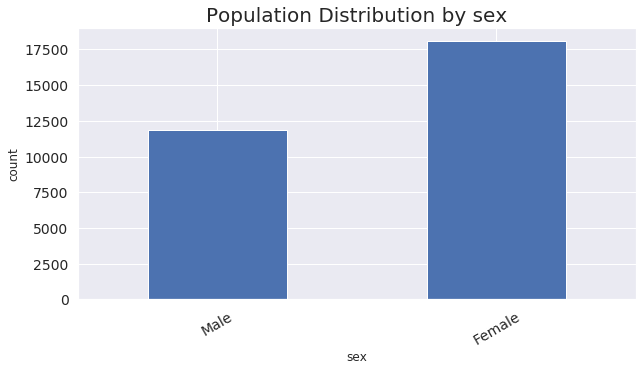

sex,Male,Female,All
default,,,
Non-default proportion,0.758328,0.792237,0.7788
Default proportion,0.241672,0.207763,0.2212
All,1.000000,1.000000,1.0000


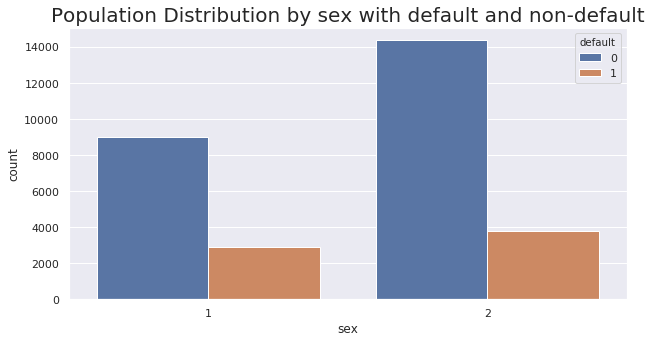

In [224]:
plt.figure(figsize=(10, 5))
_ = compare_default_across_features(cc_df, 'sex', {1: "Male", 2: "Female"})

Although there are more female credit card holders, the default proportion among men is higher. I will do a hypothesis test to see if the difference is statistically significant.

Is default proportion affected by education?

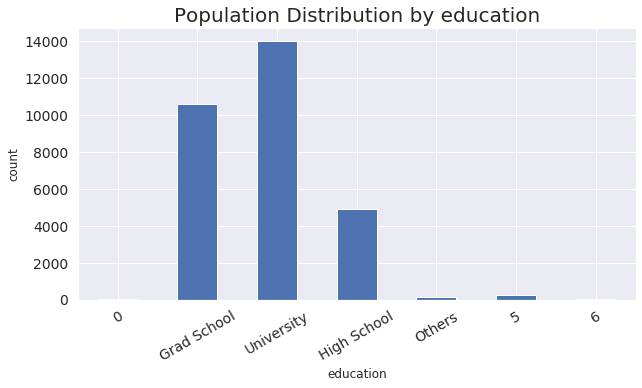

education,0,Grad School,University,High School,Others,5,6,All
default,,,,,,,,
Non-default proportion,1.0,0.807652,0.762651,0.748424,0.943089,0.935714,0.843137,0.7788
Default proportion,0.0,0.192348,0.237349,0.251576,0.056911,0.064286,0.156863,0.2212
All,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000


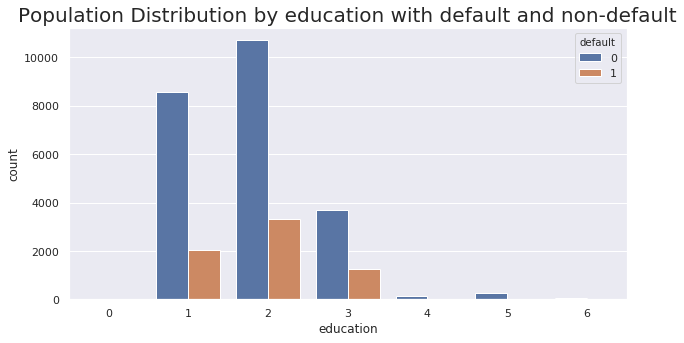

In [225]:
_ = compare_default_across_features(
    cc_df,
    "education",
    {
        0: "0",
        1: "Grad School",
        2: "University",
        3: "High School",
        4: "Others",
        5: "5",
        6: "6",
    },
)

A quick glance shows that the default proportion decreases with higher education level. This would agree with my intuition because more educated people tend to have higher paying jobs which might make it easier for them to pay back their debts.

As I mentioned earlier, I notice that there are education categories with values 0, 5 and 6 which are not explained by the data description. I could either drop those data points, keep them  or merge them with another cluster. Since there is an `Others` category, I will cluster them with that category. (This is done a bit later.)

Is default proportion affected by marital status?

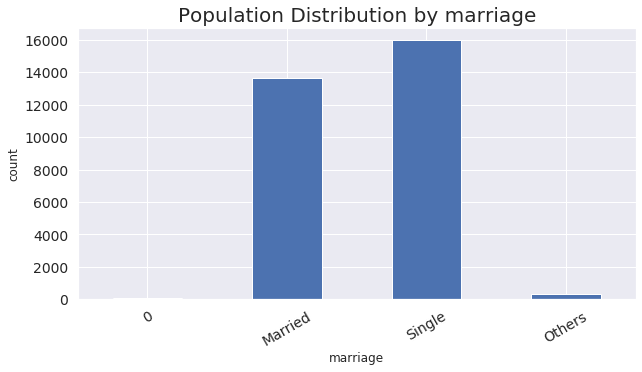

marriage,0,Married,Single,Others,All
default,,,,,
Non-default proportion,0.907407,0.765283,0.790717,0.739938,0.7788
Default proportion,0.092593,0.234717,0.209283,0.260062,0.2212
All,1.000000,1.000000,1.000000,1.000000,1.0000


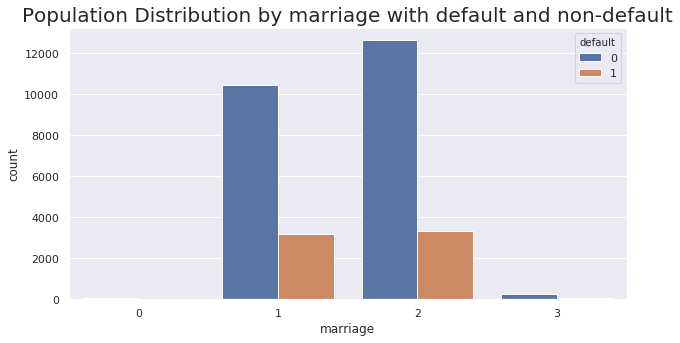

In [226]:
_ = compare_default_across_features(cc_df, 'marriage', {0:'0', 1:'Married', 2:'Single', 3:'Others'})

Married people have higher default proportions than single folks. While there are intuitive arguments for and against it, closer inspection is needed. For example, is there a difference between married men and married women?

Also, I notice that there is a marriage category with value 0. Like earlier, since there is an `Others` category, I will cluster these points with that category. (This is done a bit later.)

Is the proportion of defaults correlated with age?

Since age is a discrete variable, I have to figure out a way to bin the values. There are several ways to do this (including using the frequency and quantiles) but I will choose a simpler and more intuitive way by rounding their age to the lowest multiple of 10.

In [227]:
# Creating the age bins
cc_df['age_group'] = cc_df['age']//10
age_group_names = [str(i) + '0s' for i in range(2,8)]
age_dict = dict(zip(range(2,8), age_group_names))
#cc_df['age_bin'] = pd.cut(X['age'], 6, labels=age_group_names)

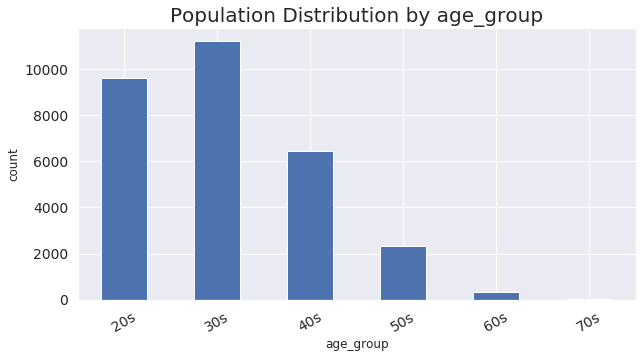

age_group,20s,30s,40s,50s,60s,70s,All
default,,,,,,,
Non-default proportion,0.771574,0.797473,0.770266,0.751388,0.716561,0.72,0.7788
Default proportion,0.228426,0.202527,0.229734,0.248612,0.283439,0.28,0.2212
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.0000


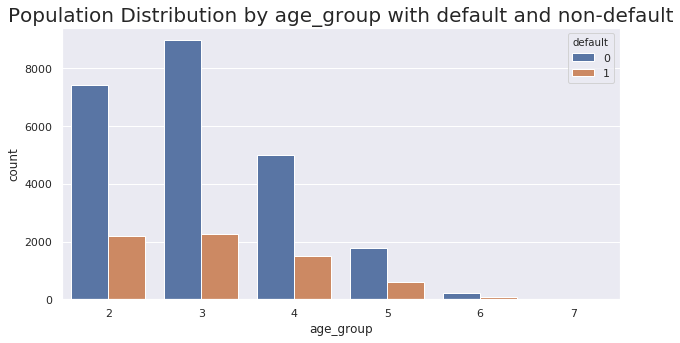

In [228]:
age_cross_tab = compare_default_across_features(cc_df, 'age_group', age_dict)

Although there is no monotonic trend in the default rate, there is some change. I look closer into the numeric values.

Default Proportion Values by age_group


{'20s': 0.22842586816385943,
 '30s': 0.20252714006050898,
 '40s': 0.2297339108910891,
 '50s': 0.24861170439982913,
 '60s': 0.28343949044585987,
 '70s': 0.28}

Text(0.5, 1.0, 'Default Proportion by age_group')

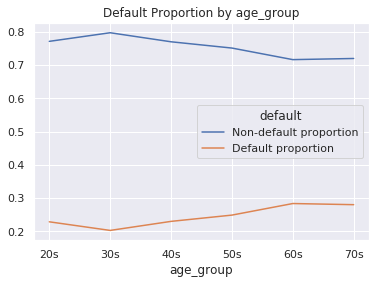

In [229]:
age_defaults = [cc_df[cc_df['age_group']==i]['default'].value_counts()[1] /
                (cc_df[cc_df['age_group']==i]['default'].value_counts()[0] + cc_df[cc_df['age_group']==i]['default'].value_counts()[1])
                for i in range (2, 8)]
print('Default Proportion Values by age_group')
display(dict(zip(age_dict.values(), age_defaults)))


age_cross_tab.iloc[:2,:6].T.plot()
plt.xticks((0, 1, 2, 3, 4, 5), age_dict.values(), rotation=0)
plt.title('Default Proportion by age_group')

It is easy to see that default proportion is lowest for people in their 30s and then steadily rises with age.

Is the default proportion affected by credit limit?

Instead of binning the credit limits, I try to see if I can analyse any trends from a density plot.

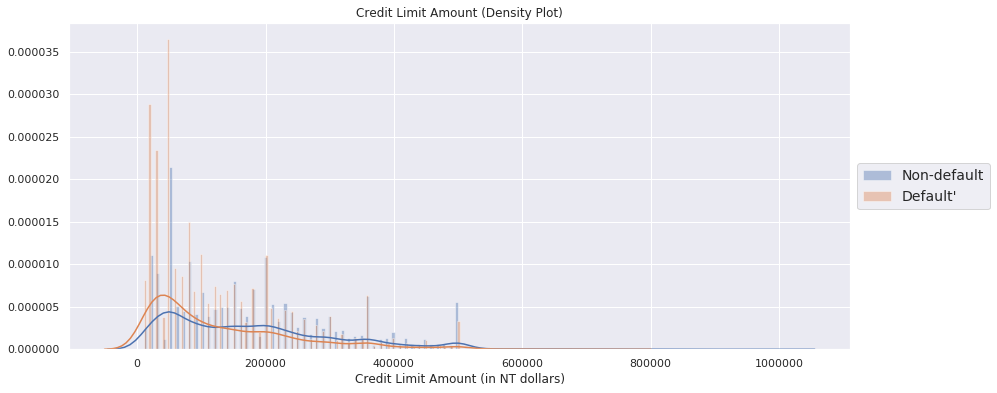

In [230]:
cc_def0 = cc_df.loc[cc_df['default'] == 0]["limit_bal"]
cc_def1 = cc_df.loc[cc_df['default'] == 1]["limit_bal"]
plt.figure(figsize = (14,6))
sns.distplot(cc_def0,kde=True,bins=200, label='Non-default')
sns.distplot(cc_def1,kde=True,bins=200, label="Default")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=14)
plt.title('Credit Limit Amount (Density Plot)')
plt.xlabel('Credit Limit Amount (in NT dollars)')
plt.show()

Looking at the density plot, it seems that people with higher credit limit have significantly lower default proportion. Again, intuitively that is not surprising because the people who have higher credit limits must have displayed long periods of fiscal responsibility to reach that place.

Is the default proportion affected by history of past repayment status?

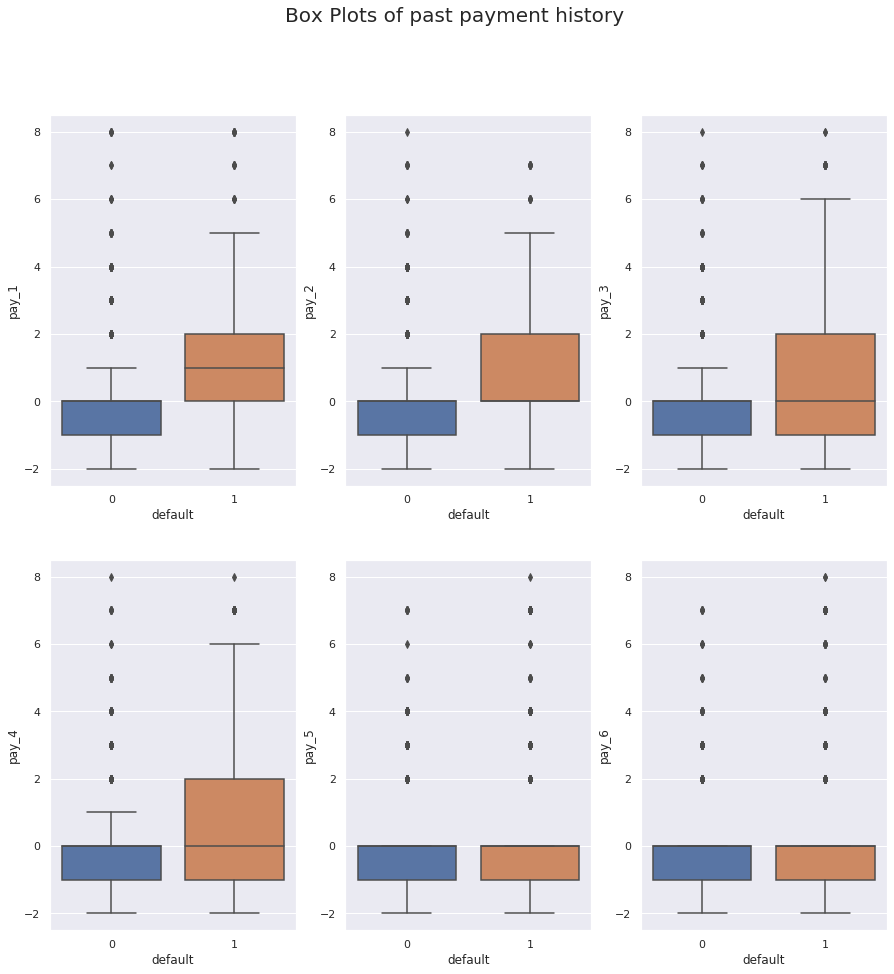

In [231]:
plt.rc('figure', figsize=(15, 15))
fig=plt.figure()
fig.suptitle('Box Plots of past payment history', fontsize=20)
for i in range(1, 7):
    plt.subplot(2, 3, i)
    y = 'pay_' + str(i)
    sns.boxplot(x='default', y=y, data=cc_df)
plt.show()

I would expect this to be very closely related to the default proportion. The box plots show that payment history in the two most recent months `pay_1` and `pay_2` is positively correlated to default. I will look at some more bar plots for a closer look.

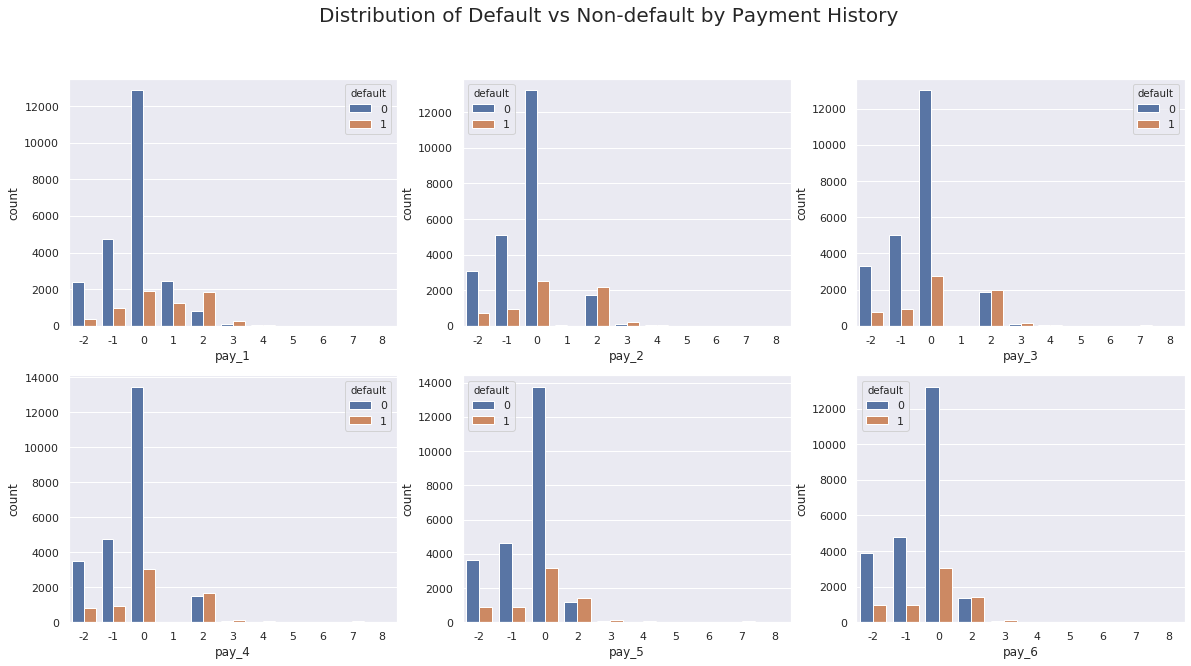

In [232]:
pay_hist = cc_df[['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'default']]

f, axes = plt.subplots(2, 3, figsize=(20, 10), facecolor='white')
f.suptitle('Distribution of Default vs Non-default by Payment History', size=20)
sns.countplot(x='pay_1', hue="default", data=pay_hist, ax=axes[0,0])
sns.countplot(x="pay_2", hue="default", data=pay_hist, ax=axes[0,1])
sns.countplot(x="pay_3", hue="default", data=pay_hist, ax=axes[0,2])
sns.countplot(x="pay_4", hue="default", data=pay_hist, ax=axes[1,0])
sns.countplot(x="pay_5", hue="default", data=pay_hist, ax=axes[1,1])
sns.countplot(x="pay_6", hue="default", data=pay_hist, ax=axes[1,2])

As remarked earlier, I notice that if the person has defaulted for 2 months or more in the past two months, there is a very high chance of them defaulting. Again, this agrees with my intuition.

A remark about the values of the payment history features. The data description mentioned that it would be taking values -1 and 1 to 9. However, I see that it takes values from -2 to 8, which is surprising.

I read the original paper but there was no further description elaboration there. However, on searching online, I found a discussion board on Kaggle https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608 where a version of this dataset is also available.

One of the commenters remarked that they had emailed the professor who created the data set and he replied that the values mean the following:  
-2: No consumption; (This would mean that the balance was paid in full and there were no further transactions.)  
-1: Paid in full; (This would mean that the balance was paid in full but the account had a positive balance.)  
0: The use of revolving credit;  (This would mean that the minimum balance was paid and the user was revolving balance.)  
1 = payment delay for one month;  
2 = payment delay for two months;  
.  
8 = payment delay for eight months;  
9 = payment delay for nine months and above.

While these explanations help clarify the discrepancy in the data, I wasn't sure if the source was reliable. This would be one of several instances where a discussion with colleagues and experts would help clarify the situation and justify the choices made. Since the default proportion across the values 0, 1 and 2 did not have wide disparity, I decided to re-assign all those values to 0. (This will be done later.)

In [233]:
def substitute_values(df, col, old_vals, new_val):
    '''
    Substitute certain values of a specific column in a dataframe.
    '''
    df[col] = np.where(df[col].isin(old_vals), new_val, df[col])

I reassign the values of `pay_i`'s, `education` and `marriage` discussed earlier.

In [234]:
for col in ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']:
    substitute_values(cc_df, col, [-2, -1, 0], 0)
    
substitute_values(cc_df, 'education', [0, 5, 6], 4)

substitute_values(cc_df, 'marriage', [0], 3)

A quick look at the negative bill amounts; their number and their default proportion.

In [235]:
for col in ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']:
    print(cc_df[cc_df[col]<0].shape)

(590, 25)
(669, 25)
(655, 25)
(675, 25)
(655, 25)
(688, 25)


In [236]:
print(cc_df[cc_df['bill_amt1']<0]['default'].value_counts(normalize=True))
cc_df[
    (cc_df["bill_amt1"] < 0)
    & (cc_df["bill_amt2"] < 0)
    & (cc_df["bill_amt3"] < 0)
    & (cc_df["bill_amt4"] < 0)
    & (cc_df['bill_amt5'] < 0)
    & (cc_df['bill_amt6'] < 0)
]["default"].value_counts(normalize=True)

0    0.815254
1    0.184746
Name: default, dtype: float64


0    0.704545
1    0.295455
Name: default, dtype: float64

If I were to use some dimension reduction like Non-negative Matrix Factorisation (it's superior to PCA because it gives interpretable "principal coordinates") which require non-negative values, I would consider dropping these values or reassigning them to 0 since they are a small percentage of the dataset. Since I will not have time for that, I will leave those values as they are.

<a id='corr'></a>
## Correlation Between the Variables<br>

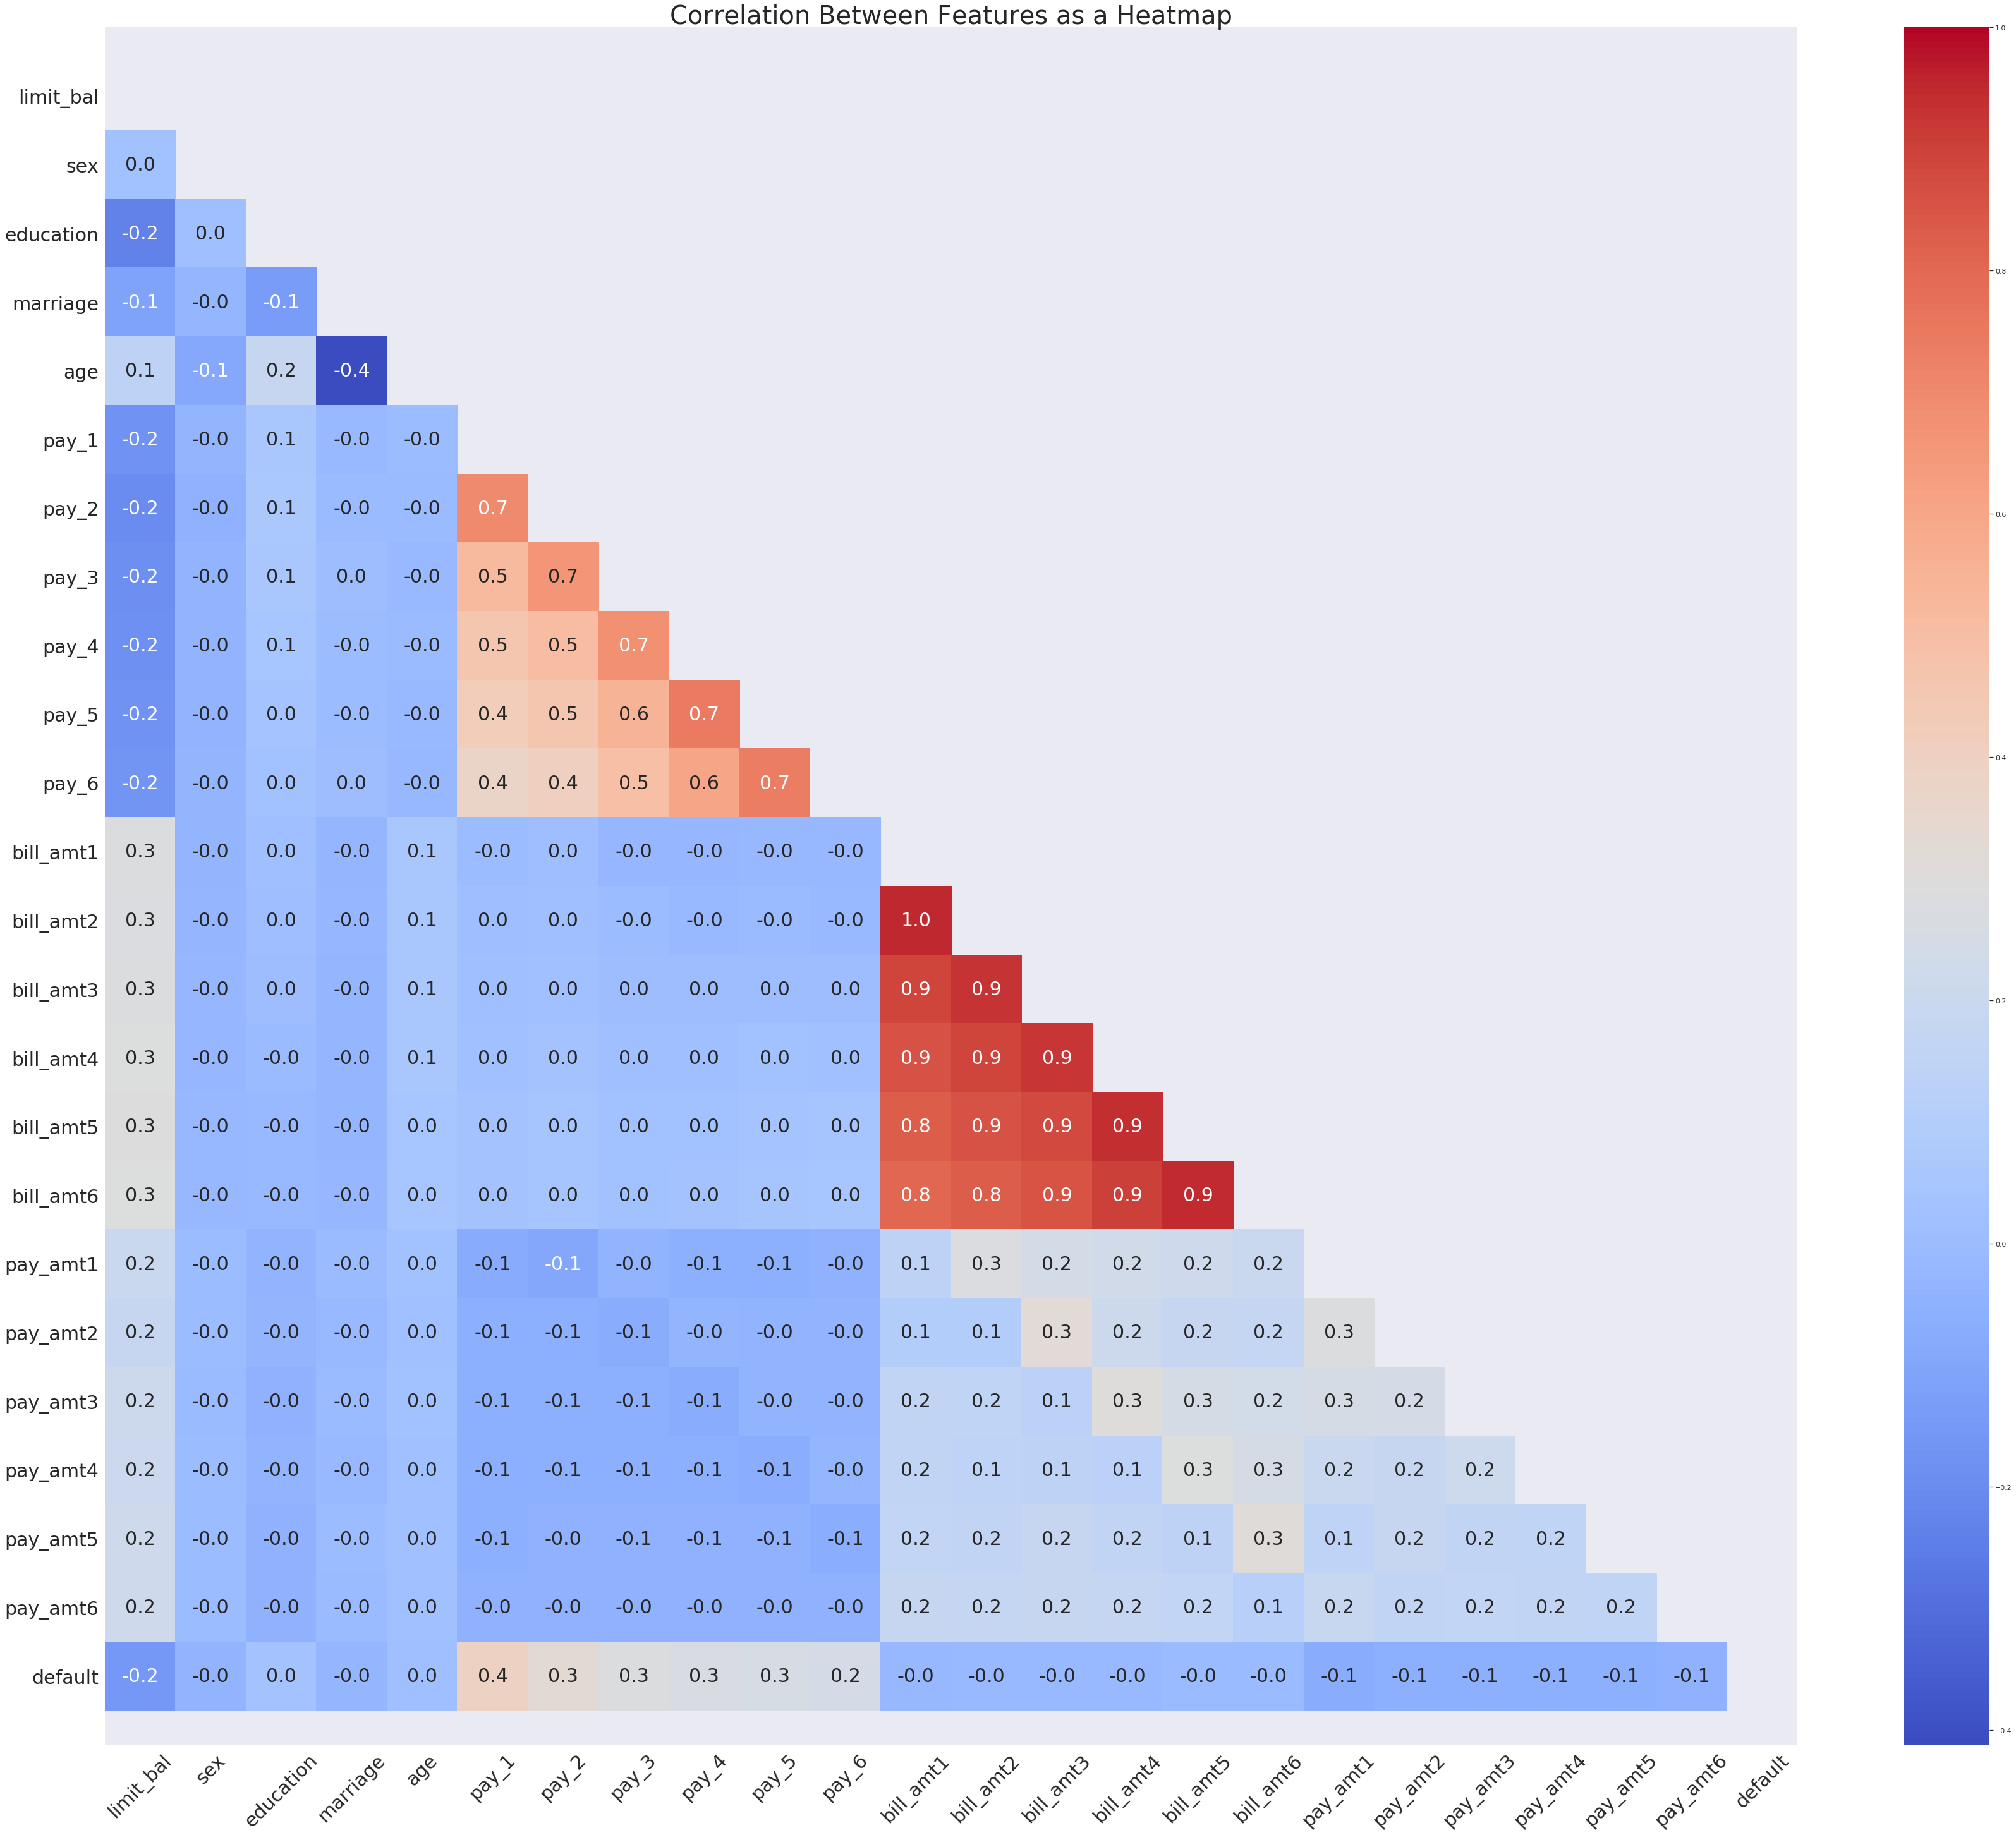

In [237]:
corr = cc_df.iloc[:, :24].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(60,50))

# Plot the heatmap
g = sns.heatmap(data=corr, annot=True, ax=ax, cmap='coolwarm',
            cbar=True, fmt='.1f',
                mask=mask, # Splits heatmap into a triangle
                annot_kws={"size":30},  #Annotation size
               );


# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Changes size of the values on the label
ax.tick_params(labelsize=30) 

ax.set_yticklabels(g.get_yticklabels(), rotation=0);
ax.set_xticklabels(g.get_xticklabels(), rotation=45);


plt.title('Correlation Between Features as a Heatmap', size=40);

What stands out are the high correlation among the payment history features and the bill amount features. I will keep this in mind as I build my models.

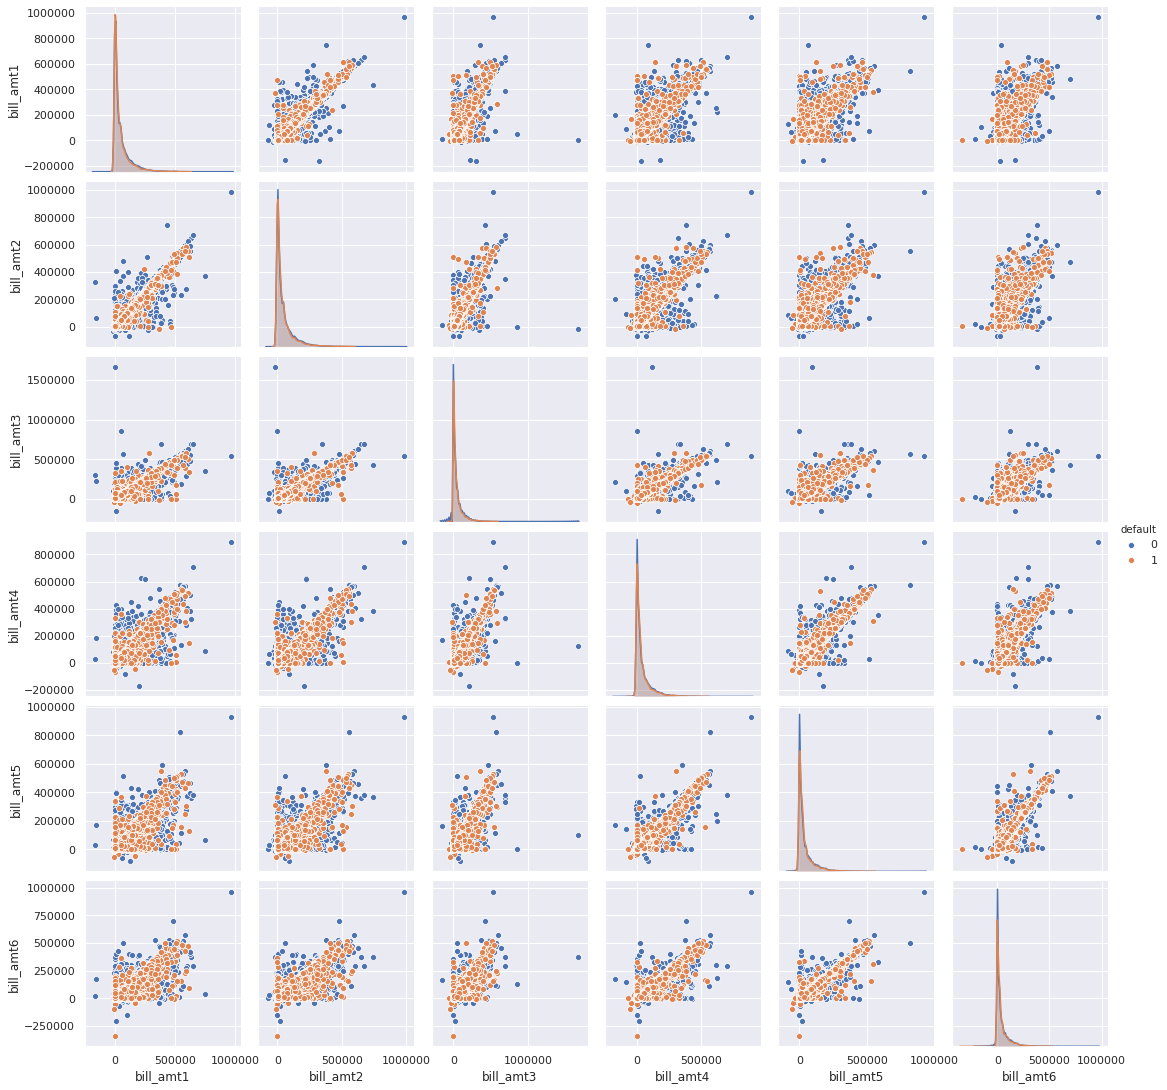

In [238]:
# Plotting the bill amount density plots and their scatter plots

sns.pairplot(cc_df, vars=cc_df.columns[11:17], kind='scatter',hue= 'default')

The distribution of the bill amounts are skewed. If the model assumptions require symmetric/normal distributions, a log transformation or a Box-Cox transformation might be warranted.

I will be using a `MinMaxScaler` later to scale the data given the presence of a lot of outliers.

<a id='s-inf'></a>
## Statistical Inference

<a id='g-def'></a>
## Is Default Affected by Gender?

Does gender affect the default rate? I will try to answer this question with a hypothesis test. As is customary, I'll use a significance level of $\alpha = 0.05$. Then the bounds of the confidence interval are given by
$[\frac{\alpha}{2}, 1 - \frac{\alpha}{2}] = [.025, .975]$.

In [239]:
alpha = 0.05
lb, ub = (alpha / 2), 1 - (alpha / 2)
ci_bounds = [lb, ub]

I want to test whether the proportion $p_m$ of men defaulting is the same as the proportion $p_w$ of women defaulting. Hence, my test statistic is the difference between $p_m$ and $p_w$.

I state the null and alternate hypotheses:  
- $H_0: p_m = p_w$.
- $H_a: p_m \neq p_w$.

In [240]:
ttest, pval = stats.ttest_ind(cc_df[cc_df['sex'] == 1]['default'], cc_df[cc_df['sex'] == 2]['default'], equal_var=False)

In [241]:
print(pval)

if pval < 0.05:
    print("The null hypothesis is rejected.")
else:
    print("The null hypothesis is accepted.")

7.562495588453789e-12
The null hypothesis is rejected.


Based on the results, the null hypothesis that $p_m = p_w$ is rejected.

<a id='f-eng'></a>
## Feature Engineering<br>

<a id='a-feat'></a>
## Adding New Features<br>

Based on my understanding of the data and conclusions from EDA, I engineer a few features.

In [242]:
cc_df['avg_default'] = cc_df.iloc[:, 5:11].sum(axis=1) / 6 # average default history
cc_df['avg_bill_amt'] = cc_df.iloc[:, 11:17].sum(axis=1) / 6 # average bill amount
cc_df['avg_pay_amt'] = cc_df.iloc[:, 18:24].sum(axis=1) / 6 # average payment amount
# There is some division by 0 in the following step. If I used this feature, I would need to address the situation.
cc_df['pay_bill_rat'] = cc_df['avg_pay_amt']/cc_df['avg_bill_amt'] # average payment to average bill ratio
cc_df['bill_bal_rat'] = cc_df['avg_bill_amt'] / cc_df['limit_bal'] # average bill amount to credit limit ratio
cc_df['pay_bal_rat'] = cc_df['avg_pay_amt'] / cc_df['limit_bal'] # average payment amount to credit limit ratio

In [243]:
print(cc_df['pay_bill_rat'].isna().sum()) # 0 divided by 0
print(cc_df[cc_df['pay_bill_rat']==np.inf].shape[0]) # non-zero divided by 0

499
371


In [244]:
cc_df.groupby('default')['avg_default'].mean()

default
0    0.160732
1    0.705721
Name: avg_default, dtype: float64

In [245]:
cc_df.groupby('default')['avg_pay_amt'].mean()

default
0    4777.013882
1    2762.208258
Name: avg_pay_amt, dtype: float64

In [246]:
cc_df.groupby('default')['limit_bal'].mean()

default
0    178099.726074
1    130109.656420
Name: limit_bal, dtype: float64

In [247]:
cc_df[cc_df["avg_bill_amt"] != 0].groupby("default")["pay_bill_rat"].mean()

default
0    0.372585
1    0.220310
Name: pay_bill_rat, dtype: float64

In [248]:
cc_df.groupby('default')['bill_bal_rat'].mean()

default
0    0.351391
1    0.449298
Name: bill_bal_rat, dtype: float64

Having engineered the features, I see if some of the aggregated columns are correlated with default. A quick look does show some relation although I would have to do some statistical tests to see if that is significant.

I draw a scatter plot of average payment amount and average bill amount and notice that there is a marked difference in slope in the line of best fit for the default and non-default class.

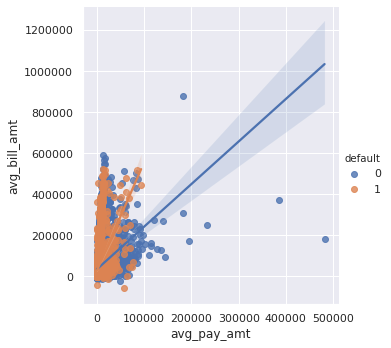

In [249]:
sns.lmplot('avg_pay_amt', 'avg_bill_amt', cc_df, hue='default')
fig = plt.gcf()
plt.show()

I engineer some more features that will be used in the models.

In [250]:
usage_labels = ['usage' + str(i) for i in range(1,7)]
pay_labels = ['pay_amt' + str(i) for i in range(1,7)]

# usagei denotes the portion of credit limit paid in month i
for i in range(0,6):
    cc_df[usage_labels[i]] = cc_df[pay_labels[i]] / cc_df['limit_bal']

zero_bal_labels = ['zero_bal' + str(i) for i in range(1,7)]
bill_labels = ['bill_amt' + str(i) for i in range(1,7)]

# zero_bali denotes the ratio of outstanding bill to credit limit
for i in range(0,6):
    cc_df[zero_bal_labels[i]] = (cc_df[bill_labels[i]] - cc_df[pay_labels[i]]) / cc_df['limit_bal']

In [251]:
cc_df[cc_df['avg_bill_amt'] > cc_df['limit_bal']]['default'].value_counts()

0    419
1    218
Name: default, dtype: int64

I notice that about one third of the people whose average bill amount was more than the credit limit defaulted. As a result, I engineer a feature called `overdraft` which takes value 1 if the user defaulted at any point in the past 6 months.

In [252]:
cc_df['overdraft'] = np.where(
    (cc_df['bill_amt1'] > cc_df['limit_bal']) |
    (cc_df['bill_amt2'] > cc_df['limit_bal']) |
    (cc_df['bill_amt3'] > cc_df['limit_bal']) |
    (cc_df['bill_amt4'] > cc_df['limit_bal']) |
    (cc_df['bill_amt5'] > cc_df['limit_bal']) |
    (cc_df['bill_amt6'] > cc_df['limit_bal']), 1, 0
)

In [253]:
cc_df[cc_df['overdraft'] == 1]['default'].value_counts()

0    2748
1    1183
Name: default, dtype: int64

The original dataset had three categorical demographic variables (`sex`, `marriage` and `education`). Among them `education` has an ordinal structure as the changes in value lead to more or less education. `sex` had only two classes and so is already one-hot-encoded. I will now one-hot-encode the `marriage` variable.

<a id='e-cat'></a>
## Encoding Categorical Data<br>

In [254]:
# One-Hot_encoding the marriage column and dropping the first column
j = cc_df.columns.get_loc("marriage")

left = cc_df.iloc[:, :j]
marriage = pd.get_dummies(cc_df["marriage"], prefix="marriage", drop_first=True)
right = cc_df.iloc[:, j + 1 :]

cc_df = pd.concat([left, marriage, right], axis=1)

<a id='ml'></a>
## Machine Learning: Classification Models<br>

<a id='f-sel'></a>
## Feature Selection, Scaling, Splitting and Balancing the Data<br>

In [255]:
def make_stratified_tts(df, features, target='default', scaled=False, balanced=False, test_size=0.2, random_state=1):
    '''
    This function takes in a dataframe, the feature variables, the target variables
    and then splits the data with the user having the option to scale and balance the data
    and set values for the split proportion and the random seed.
    '''
    # Resampling methods
    random_os = RandomOverSampler() # oversampling
    smote = SMOTE() # smote

    X, y = df[features], df[target]

    # Checking if X needs to be scaled
    if scaled == True:
        X_sc = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
    else:
        X_sc = X
    
    # Executing sklearn's train-test split
    X_sc_train, X_sc_test, y_train, y_test = tts(
    X_sc, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    # Checking if training data needs to be balanced
    if balanced == 'random_os':
        X_sc_train_rs, y_sc_train_rs = random_os.fit_sample(X_sc_train, y_train)
    elif balanced == 'smote':
        X_sc_train_rs, y_sc_train_rs = smote.fit_sample(X_sc_train, y_train)
    else:
        X_sc_train_rs, y_sc_train_rs = X_sc_train, y_train        
        
    return X_sc_train_rs, X_sc_test, y_sc_train_rs, y_test


This is the original data set, along with some minor data adjustments discussed earlier and the one-hot encoding of the marriage feature.

In [256]:
features_1 = list(cc_df.columns[:24])
X1_train, X1_test, y_train, y_test = make_stratified_tts(cc_df, features_1)
print(features_1)
X1 = cc_df[features_1]

['limit_bal', 'sex', 'education', 'marriage_2', 'marriage_3', 'age', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']


This dataset contains features that avoid multicollinearity in the model (and hence, statistically significant non-zero coefficients in a logistic model). I decide on this list by looking at the vif and deviance reduction and also at the feature importances of the models. The dataset is then scaled and the training set balanced.

In [257]:
features_best = (
    list(cc_df.columns[0:5])
    + list(cc_df.columns[6:12])
    + list(cc_df.columns[18:24])
    + [cc_df.columns[25]]
    + [cc_df.columns[27]]
    + list(cc_df.columns[31: 34])
    + [cc_df.columns[36]]
    + list(cc_df.columns[38: 40])
    + [cc_df.columns[42]]
)
X3_sc_train_rs1, X3_sc_test, y3_sc_train_rs1, y_test = make_stratified_tts(cc_df, features_best, scaled=True, balanced='smote')
X3_sc_train_rs2, X3_sc_test, y3_sc_train_rs2, y_test = make_stratified_tts(cc_df, features_best, scaled=True, balanced='random_os')
print(features_best)
X3 = cc_df[features_best]

['limit_bal', 'sex', 'education', 'marriage_2', 'marriage_3', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'age_group', 'avg_bill_amt', 'pay_bal_rat', 'usage1', 'usage2', 'usage5', 'zero_bal1', 'zero_bal2', 'zero_bal5']


In [273]:
def plot_feat_imp(X_train, model):
    """
    Prints the model feature importances
    """
    feat_imp = pd.DataFrame(
        {"Feature": X_train.columns, "Feature Importance": model.feature_importances_}
    )
    feat_imp.sort_values(by="Feature Importance", ascending=False, inplace=True)
    plt.figure(figsize=(10, 5))
    plt.title(f"Feature Importance of {model}", fontsize=14)
    ax = sns.barplot(x="Feature", y="Feature Importance", data=feat_imp)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()
    
def get_model_results(X_train, X_test, y_train, y_test, model, feat_imp=False):
    """
    Prints the training and test metrics and plots the confusion matrices.
    Also plots the feature importance based on the user choosing the parameter variable,
    and returns the evaluation metrics.
    """
    # Fit training model to training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model
    y_train_pred = model.predict(X_train)
    y_train_pred_probs = model.predict_proba(X_train)

    y_test_pred = model.predict(X_test)
    y_test_pred_probs = model.predict_proba(X_test)

    # Get confusion matrix
    train_matrix = metrics.confusion_matrix(y_train, y_train_pred)
    test_matrix = metrics.confusion_matrix(y_test, y_test_pred)

    # Get F1 score
    f1_train = metrics.f1_score(y_train, y_train_pred)
    f1_test = metrics.f1_score(y_test, y_test_pred)

    # Print the train and test roc_auc_score
    #and test confusion matrix
    print(
        f"ROC_AUC_Score of train set is {metrics.roc_auc_score(y_train, y_train_pred_probs[:, 1])}."
    )
    print(
        f"ROC_AUC_Score of test set is {metrics.roc_auc_score(y_test, y_test_pred_probs[:, 1])}."
    )
    #print("Confusion matrix of test set\n", confusion_matrix(y_test, y_test_pred))
    #print(
    #    "Classification Report of test set\n",
    #    metrics.classification_report(y_test, y_test_pred),
    #)
    
    # Display scores
    print(f"F1 of train set is {f1_train.round(4)}.")
    print(f"F1 of test set is {f1_test.round(4)}.")

    # Plot training and test confusion matrices
    plt.figure(figsize=(12, 4))
    names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    train_percent = [
        "{0:.2%}".format(value)
        for value in train_matrix.flatten() / np.sum(train_matrix)
    ]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(names, train_percent)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.subplot(1, 2, 1)
    sns.heatmap(train_matrix, annot=labels, fmt="", cmap="Blues")
    plt.title("Train Set\n")

    names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    test_percent = [
        "{0:.2%}".format(value) for value in test_matrix.flatten() / np.sum(test_matrix)
    ]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(names, test_percent)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.subplot(1, 2, 2)
    sns.heatmap(test_matrix, annot=labels, fmt="", cmap="Blues")
    plt.title("Test Set\n")

    plt.subplots_adjust(wspace=0.2)

    #plt.figure(figsize=(7, 4))
    #plot_roc_curve(model, X_test, y_test)
    #plt.show()

    if feat_imp == True:
        plot_feat_imp(X_train, model)
    elif feat_imp == "LR":
        # Get feature coefficients
        importance = model.coef_[0]

        df_feat_imp = pd.DataFrame(
            columns=["Feature", "Feature Importance (Value of Coefficient)"]
        )
        
        # Attach feature coefficients to labels
        for i, v in enumerate(importance):
            df_feat_imp = df_feat_imp.append(
                {
                    "Feature": X_train.columns[i],
                    "Feature Importance (Value of Coefficient)": v,
                },
                ignore_index=True,
            )

            #print(f"{X_train.columns[i]} Feature: %0d, Score: %.5f" % (i, v))
        
        # Sort them by their absolute values in descending order
        df_feat_imp = df_feat_imp.reindex(
            df_feat_imp["Feature Importance (Value of Coefficient)"]
            .abs()
            .sort_values(ascending=False)
            .index
        )
        
        # Plot a bargraph
        plt.figure(figsize=(10, 5))
        plt.title(f"Feature Importance of {model}", fontsize=14)
        ax = sns.barplot(x="Feature", y="Feature Importance (Value of Coefficient)", data=df_feat_imp)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.show()
        
    else:
        pass
    
    return metrics.accuracy_score(y_test, y_test_pred),\
           metrics.precision_score(y_test, y_test_pred),\
           metrics.recall_score(y_test, y_test_pred),\
           metrics.f1_score(y_test, y_test_pred),\
           metrics.roc_auc_score(y_test, y_test_pred_probs[:, 1])

<a id='vif'></a>
## VIF and Deviance Reduction for Feature Selection (in Logistic Regression)<br>

I use the variance inflation factor and reduction of model deviance to quantitatively look at the multicollinearity of features. I will use the commonly considered threshold of 2.5, i.e., if a feature has vif greater than 2.5., it exhibits strong multicollinearity with the other features which leads to the inflation of standard errors, leading to the coefficients' (being non-zero) not being statistically significant.

In [259]:
# Get variables for which to compute VIF and add intercept term
X1['intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = X1.columns
vif["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]

vif.sort_values(by='VIF', ascending=False)

,variables,VIF
24,intercept,48.567648
13,bill_amt2,25.789749
16,bill_amt5,24.920308
14,bill_amt3,21.741748
15,bill_amt4,20.257259
17,bill_amt6,14.982327
12,bill_amt1,13.980935
10,pay_5,3.251529
9,pay_4,2.968966
7,pay_2,2.620972


We noticed earlier and the vif scores reinforce that the bill amount variables are highly correlated. I will later notice that they are not among the important features either making them good candidate features to be dropped.

In [260]:
X3 = cc_df[features_best]
# Get variables for which to compute VIF and add intercept term
X3['intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = X3.columns
vif["VIF"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]

vif.sort_values(by='VIF', ascending=False)

,variables,VIF
26,intercept,46.603093
24,zero_bal2,12.974577
23,zero_bal1,10.379303
19,pay_bal_rat,5.109554
21,usage2,4.853109
20,usage1,4.035254
22,usage5,3.426105
25,zero_bal5,3.414655
9,pay_5,3.255039
8,pay_4,2.995284


The collinearity of the variables has been reduced when we look at our best features.

In [310]:
# Define model formula
formula1 = "default ~ limit_bal + sex + education + marriage_2 + marriage_3 + age + pay_1 + pay_2 + pay_3 + pay_4\
            + pay_5 + pay_6 + bill_amt1 + bill_amt2 + bill_amt3 + bill_amt4 + bill_amt5 + bill_amt6 + pay_amt1 +\
            pay_amt2 + pay_amt3 + pay_amt4 + pay_amt5 + pay_amt6"

# Fit GLM
model_glm = glm(formula1, data=cc_df, family=sm.families.Binomial()).fit()

# Compare the reduction of deviance in current model from null model and print it
diff_deviance = model_glm.null_deviance - model_glm.deviance
print("The reduction in model deviance for this model is:", diff_deviance)

# Print the model summary
model_glm.summary()

The reduction in model deviance for this model is: 5003.059679279901


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29975
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13351.
Date:                Sat, 20 Feb 2021   Deviance:                       26702.
Time:                        09:08:03   Pearson chi2:                 5.32e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2357      0.107    -11.528      0.000      -1.446      -1.026
limit_bal  -1.505e-06   1.55e-07     -9.712      0.000   -1.81e-06    -1.2e-06
sex           -0.1263      0.032     -3.979      0.000      -0.188      -0.064
education     -0.0767      0.023     -3.400      0.001      -0.121      -0.033
marriage_2    -0.1752      0.036     -4.916      0.000      -0.245      -0.105
marriage_3    -0.1317      0.137     -0.963      0.336      -0.400       0.136
age            0.0048      0.002      2.492      0.013       0.001       0.008
pay_1          0.8836      0.025     35.193      0.000       0.834       0.933
pay_2          0.0449      0.027      1.692      0.091      -0.007       0.097
pay_3          0.1250      0.028      4.399      0.000       0.069       0.181
pay_4          0.0765      0.032      2.416      0.016       0.014       0.139
pay_5          0.0936      0.034      2.735      0.006       0.027       0.161
pay_6          0.1584      0.029      5.455      0.000       0.102       0.215
bill_amt1  -2.322e-06   1.07e-06     -2.176      0.030   -4.41e-06   -2.31e-07
bill_amt2   2.383e-06   1.43e-06      1.669      0.095   -4.15e-07    5.18e-06
bill_amt3   1.676e-06   1.28e-06      1.309      0.190   -8.33e-07    4.18e-06
bill_amt4    -8.3e-08    1.3e-06     -0.064      0.949   -2.64e-06    2.47e-06
bill_amt5  -5.829e-07    1.5e-06     -0.389      0.698   -3.52e-06    2.36e-06
bill_amt6  -1.195e-07    1.2e-06     -0.100      0.920   -2.47e-06    2.23e-06
pay_amt1   -1.179e-05   2.24e-06     -5.252      0.000   -1.62e-05   -7.39e-06
pay_amt2   -8.673e-06   2.05e-06     -4.230      0.000   -1.27e-05   -4.65e-06
pay_amt3   -1.779e-06   1.66e-06     -1.070      0.285   -5.04e-06    1.48e-06
pay_amt4   -2.901e-06   1.76e-06     -1.647      0.100   -6.35e-06    5.52e-07
pay_amt5   -2.919e-06   1.78e-06     -1.641      0.101   -6.41e-06    5.68e-07
pay_amt6   -2.757e-06   1.34e-06     -2.060      0.039   -5.38e-06   -1.34e-07
==============================================================================
"""

I notice that not all of these coefficients are non-zero in a statistically significant way. I will use this information along with the feature importances to finalise my best features. However, this will be something to come back to after an initial round of modelling.

In [311]:
# Define model formula
formula2 = "default ~ limit_bal + sex + education + marriage_2 + marriage_3 + pay_1 + pay_2 + pay_3 + pay_4\
            + pay_5 + pay_6 + pay_amt1 + pay_amt2 + pay_amt3 + pay_amt4 + pay_amt5 + pay_amt6 + age_group +\
            avg_bill_amt + pay_bal_rat + usage1 + usage2 + usage5 + zero_bal1 + zero_bal2 + zero_bal5"

# Fit GLM
model_glm = glm(formula2, data=cc_df, family=sm.families.Binomial()).fit()

# Compare the reduction of deviance in current model from null model and print it
diff_deviance = model_glm.null_deviance - model_glm.deviance
print("The reduction in model deviance for this model is:", diff_deviance)

# Print the model summary
model_glm.summary()

The reduction in model deviance for this model is: 5018.449967059481


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29973
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13343.
Date:                Sat, 20 Feb 2021   Deviance:                       26687.
Time:                        09:08:27   Pearson chi2:                 5.31e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.1541      0.106    -10.939      0.000      -1.361      -0.947
limit_bal      -1.7e-06   2.08e-07     -8.155      0.000   -2.11e-06   -1.29e-06
sex             -0.1280      0.032     -4.026      0.000      -0.190      -0.066
education       -0.0746      0.023     -3.299      0.001      -0.119      -0.030
marriage_2      -0.1758      0.035     -4.967      0.000      -0.245      -0.106
marriage_3      -0.1222      0.137     -0.893      0.372      -0.390       0.146
pay_1            0.8811      0.025     35.129      0.000       0.832       0.930
pay_2            0.0609      0.027      2.271      0.023       0.008       0.114
pay_3            0.1066      0.029      3.690      0.000       0.050       0.163
pay_4            0.0849      0.032      2.658      0.008       0.022       0.147
pay_5            0.0918      0.034      2.683      0.007       0.025       0.159
pay_6            0.1575      0.029      5.392      0.000       0.100       0.215
pay_amt1     -1.574e-05   2.94e-06     -5.347      0.000   -2.15e-05   -9.97e-06
pay_amt2     -4.605e-06   2.33e-06     -1.975      0.048   -9.18e-06   -3.44e-08
pay_amt3     -2.854e-06    1.6e-06     -1.780      0.075      -6e-06    2.89e-07
pay_amt4     -3.658e-06   1.75e-06     -2.094      0.036   -7.08e-06   -2.34e-07
pay_amt5     -2.068e-06   2.09e-06     -0.991      0.322   -6.16e-06    2.02e-06
pay_amt6     -3.013e-06   1.49e-06     -2.024      0.043   -5.93e-06   -9.51e-08
age_group        0.0448      0.018      2.499      0.012       0.010       0.080
avg_bill_amt  1.603e-06   4.45e-07      3.604      0.000    7.31e-07    2.47e-06
pay_bal_rat      0.3750      0.795      0.472      0.637      -1.183       1.933
usage1           0.1581      0.332      0.477      0.634      -0.492       0.808
usage2          -0.2132      0.363     -0.587      0.557      -0.925       0.499
usage5          -0.3786      0.340     -1.112      0.266      -1.046       0.288
zero_bal1       -0.3726      0.129     -2.885      0.004      -0.626      -0.119
zero_bal2        0.3613      0.141      2.563      0.010       0.085       0.637
zero_bal5       -0.1064      0.080     -1.328      0.184      -0.263       0.051
================================================================================
"""

There is a greater reduction in model deviance and except for a couple of the variables, the coefficients are non-zero with high statistical significance.

<a id='lr'></a>
## Logistic Regression Model<br>

ROC_AUC_Score of train set is 0.6444400940803303.
ROC_AUC_Score of test set is 0.6415277296454113.
F1 of train set is 0.0.
F1 of test set is 0.0.


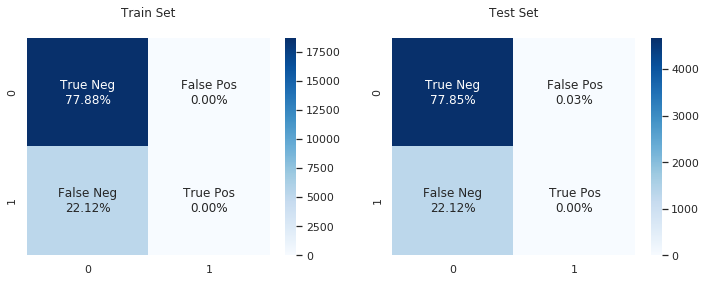

In [299]:
# Instantiate a Logistic Regression model
log_model = LogisticRegression(random_state=0, max_iter=200)

# Train the model on the original data set and diplay the performance
acc, prec, rec, f1, auc = get_model_results(X1_train, X1_test, y_train, y_test, log_model)

It is not surprising that the model is performing so poorly as it is classifying everything as non-default. Let's see if the performance improves as we wrangle the dataset.

In [300]:
# Storing model results in a dataframe for comparison
model_results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC_ROC"])

model = pd.DataFrame(
    [["Logistic Regression (original data)", acc, prec, rec, f1, auc]],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC_ROC"],
)
model_results = model_results.append(model, ignore_index=True)


This is a Logistic Regression modelled on the best features dataset. The feature importances here will justify/reinforce some of the choices I have made.

ROC_AUC_Score of train set is 0.7606294754509688.
ROC_AUC_Score of test set is 0.7578931123349499.
F1 of train set is 0.6522.
F1 of test set is 0.5331.


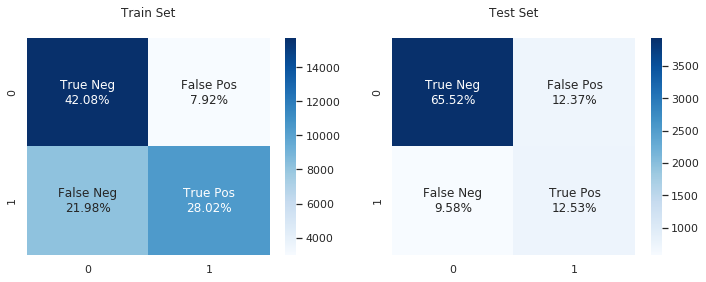

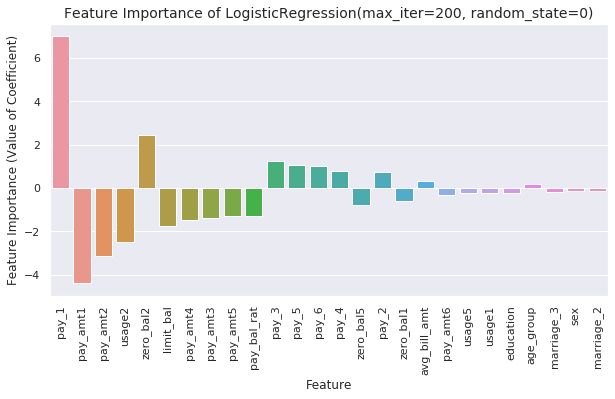

In [301]:
# Train the model on the scaled, resampled data set of the best features and diplay the performance
acc, prec, rec, f1, auc = get_model_results(X3_sc_train_rs2, X3_sc_test, y3_sc_train_rs2, y_test, log_model, feat_imp='LR')

The model is performing markedly better. Further, the most important features include the payment history and some of the engineered features like usage, zero balance and the credit limit. This agrees with our intuition and the insights I had drawn from EDA.

In [302]:
# Updating model results dataframe

model = pd.DataFrame(
    [["Logistic Regression (engineered data)", acc, prec, rec, f1, auc]],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC_ROC"],
)
model_results = model_results.append(model, ignore_index=True)

I tried tuning the regularisation parameter and tuning the model by using the `class_weight` parameter but performance remained about the same.

<a id='rf'></a>
## Random-Forest Classifier<br>

ROC_AUC_Score of train set is 1.0.
ROC_AUC_Score of test set is 0.7835423913062759.
F1 of train set is 1.0.
F1 of test set is 0.5495.


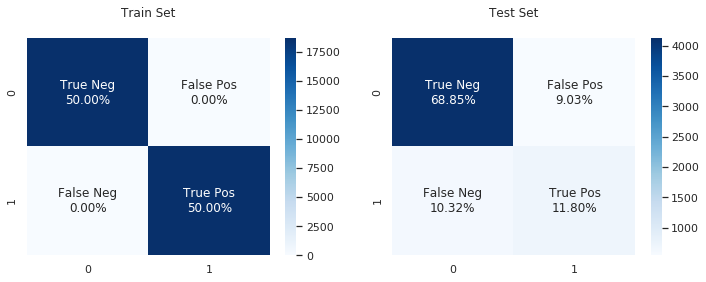

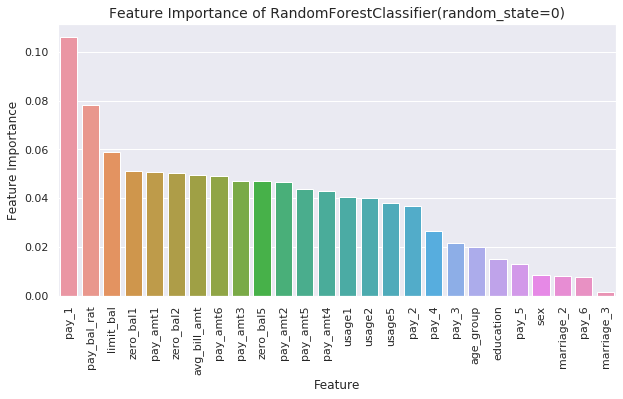

In [303]:
rf_model = RandomForestClassifier(random_state=0)

acc, prec, rec, f1, auc = get_model_results(X3_sc_train_rs1, X3_sc_test, y3_sc_train_rs1, y_test, rf_model, feat_imp=True)

The random forest model on the best features dataset does not necessarily return the feature importances in the same order but the past payment history and credit limit are still among the very top. This is an untuned dataset and I will see if I can improve model performance by tuning the hyperparameters.

In [304]:
# Updating model results dataframe

model = pd.DataFrame(
    [["Untuned Random Forest Model", acc, prec, rec, f1, auc]],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC_ROC"],
)
model_results = model_results.append(model, ignore_index=True)

In [266]:
# Setting up a parameter grid for hyperparameter tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 25, num = 6)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [0, 5, 10, 15, 20, 25, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 4, 6, 8, 10],
 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}


In [ ]:
# Using the random grid to search for best hyperparameters

# First create the base model to tune
rf_model = RandomForestClassifier()

# Random search of parameters, using 5 fold cross validation,
# search across 50 different combinations
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 10, cv = 5, scoring='recall', verbose=2, random_state=0, n_jobs = -1)

# Fit the random search model
rf_random.fit(X3_sc_train_rs1, y3_sc_train_rs1)

In [267]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25,
 'bootstrap': True}

ROC_AUC_Score of train set is 0.999999713756967.
ROC_AUC_Score of test set is 0.7884613803002739.
F1 of train set is 0.9998.
F1 of test set is 0.5518.


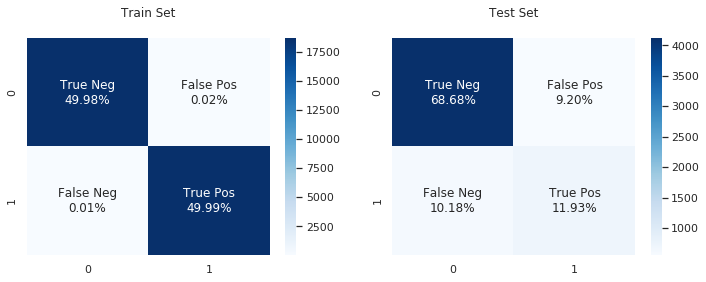

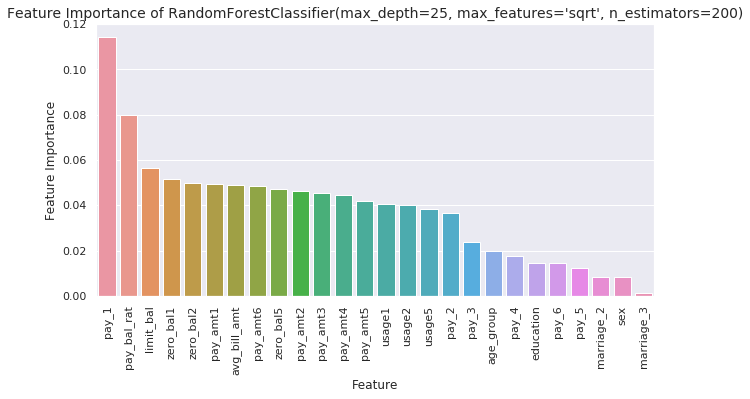

In [305]:
# Instantiating the best model
rf_best_random = rf_random.best_estimator_

# I am using resampled data as I am not using class_weight ={0:1, 1:4} to balance

acc, prec, rec, f1, auc = get_model_results(X3_sc_train_rs1, X3_sc_test, y3_sc_train_rs1, y_test, rf_best_random, feat_imp=True)

The model is now correctly identifying more than half of the defaulters with high accuracy, precision and AUC_ROC score. Although it is still missing many of the defaulters, this is a good starting point for further refining the model. Once again, the same features are showing up as few of the most important features.

Although recall is our primary metric of concern here (as credit card defaults can be quite expensive for the bank), it is important not to lose sight of the precision (as banks don't want to lose potential customers by mis-classifying them as defaulters). This balance is something where the ML/DS team and the business team need to sit and do a cost benefit analysis.

In [306]:
# Updating model results dataframe

model = pd.DataFrame(
    [["Tuned Random Forest Model", acc, prec, rec, f1, auc]],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC_ROC"],
)
model_results = model_results.append(model, ignore_index=True)

<a id='xgb'></a>
## Gradient Boosting Classifier<br>

ROC_AUC_Score of train set is 0.8365189668741271.
ROC_AUC_Score of test set is 0.8057671811853145.
F1 of train set is 0.7242.
F1 of test set is 0.5761.


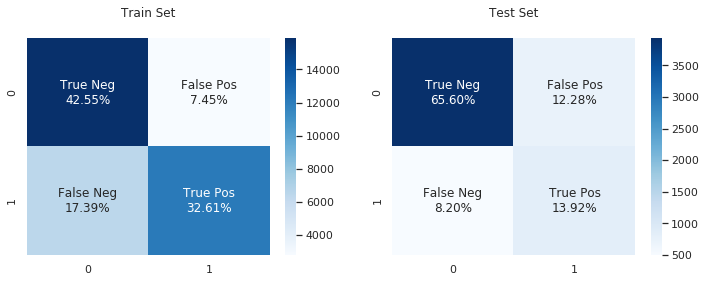

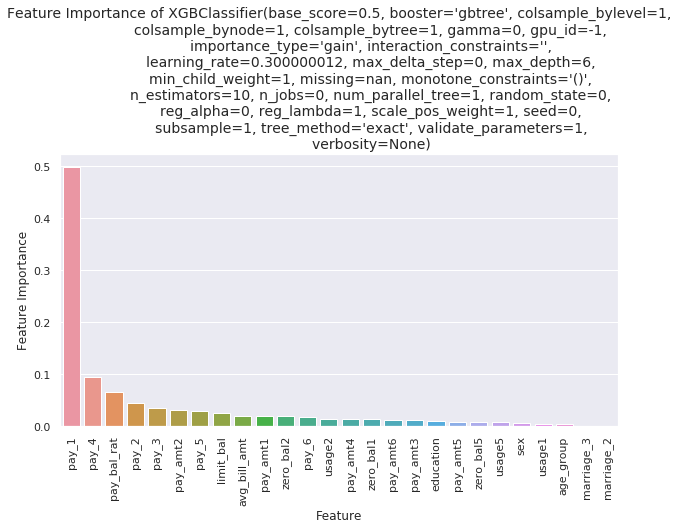

In [307]:
# Instantiating an XGBoost classifier.
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=0)

acc, prec, rec, f1, auc = get_model_results(X3_sc_train_rs2, X3_sc_test, y3_sc_train_rs2, y_test, xgb_model, feat_imp=True)

The XGBoost model has lower false negatives than the tuned Random Forest but it has a bit higher false positives. This is a reflection of how important it is to have thresholds so that the bank can balance potential losses with potential revenue from new customers. I also talk later about how the model can be used in ways beyond "just" a classifier; it can be used to make informed recommendations.

In [308]:
# Updating model results dataframe

model = pd.DataFrame(
    [["Gradient Boosting Classifier", acc, prec, rec, f1, auc]],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC_ROC"],
)
model_results = model_results.append(model, ignore_index=True)

I tune a few hyperparameters but if I had more time, I would set up a pipeline so that all the processes can be covered in one step. I would start with a couple of `RandomizedSearch` results (to avoid the huge expensive costs of a GridSearch on the whole parameter grid) and use those as a starting point for smaller, more efficient grids which can be exhaustively covered by `GridSearch.

In [312]:
xgb_model = xgb.XGBClassifier()

# Create the parameter grid
xgb_param_grid = {
    'clf__learning_rate': np.arange(.05, 1, .05),
    'clf__max_depth': np.arange(3, 10, 1),
    'clf__n_estimators': np.arange(50, 200, 50)
}

# Perform RandomizedSearchCV
randomised_xgb = RandomizedSearchCV(estimator=xgb_model, n_iter=2, scoring='roc_auc', verbose=1,
                                        cv=2, param_distributions=xgb_param_grid)

# Fit the estimator
randomised_xgb.fit(X3_sc_train_rs1, y3_sc_train_rs1)

# Compute metrics
#print(randomized_roc_auc.best_score_)
print(randomised_xgb.best_estimator_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[09:22:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { clf__learning_rate, clf__max_depth, clf__n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:22:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { clf__learning_rate, clf__max_depth, clf__n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:22:55] WARNING: /home/conda/feedstock_root/build_artifact

ROC_AUC_Score of train set is 0.9759561605742237.
ROC_AUC_Score of test set is 0.77586258889795.
F1 of train set is 0.9142.
F1 of test set is 0.5353.


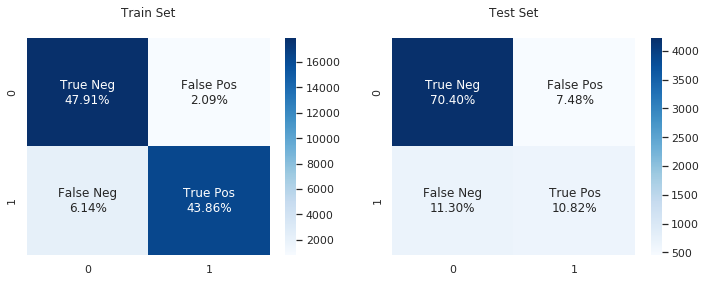

In [271]:
get_model_results(X3_sc_train_rs1, X3_sc_test, y3_sc_train_rs1, y_test, xgb_model)

<a id='comp'></a>
## Comparison of Model Performance

In [309]:
model_results

,Model,Accuracy,Precision,Recall,F1 Score,AUC_ROC
0,Logistic Regression (original data),0.778500,0.000000,0.000000,0.000000,0.641528
1,Logistic Regression (engineered data),0.780500,0.503347,0.566692,0.533144,0.757893
2,Untuned Random Forest Model,0.806500,0.566400,0.533534,0.549476,0.783542
3,Tuned Random Forest Model,0.806167,0.564669,0.539563,0.551830,0.788461
4,Gradient Boosting Classifier,0.795167,0.531170,0.629239,0.576061,0.805767


- Other than the naive logistic regression on the original dataset, all of the models have pretty good AUC_ROC scores. For example, the gradient boosting classifier assigns a higher probability of default to a defaulter over a non-defaulter with almost 81% certainty. Also, a lot of the engineered features are some of the most important features and that implies that the data reflects what an analyst would intuitively think to be true.
- The precision-recall trade-off is something that will need to be closely looked at. We could improve our recall but that would come at the cost of precision. It might be worth treating this as a regression problem to model the total amount of money lost by the bank instead of a binary classification problem.
- The best predictor (by far) of delinquency is the behaviour in the past couple of months, and in particular the last month. Banks can start using that information to plan in advance and reach out to the customer.
- The credit limit is a good indicator of financial stability. Whatever mechanism the bank is currently using works well and some of the features that go into choosing the credit line can be used directly in the model for default prediction.
- Although a gradient boosted model or a tuned random forest model might perform better, it might be worth working on a logistic regression model (especially if the model complexity can be reduced by dropping irrelevant features). A deployable model doesn't just need to be reliable, it also needs to be fast.

<a id='take'></a>
## Takeaways<br>

<a id='f-work'></a>
## Future Work<br>

The above is by no means an exhaustive attempt at the problem. Given more time, some additional things I would do are (roughly, in this order):
- One-Hot-Encode the age group to see if it improves model performance.
- Compare the effect of dropping some of the discrepant data points discussed earlier in the work. Also consider removing the negative-valued data points so that I could use non-negative matrix factorisation (NMF) for efficient feature space reduction leading to a leaner, better performing model.
- Measure the amount of improvement in ensembling or stacking models to improve predictive performance (and compare it to the loss of interpretability). This would also mean trying some other models like a Naive Bayes or KNN and then use a `VotingClassifier`.
- Follow the `RandomizedSearchCV` with a couple of `GridSearchCV`'s on smaller grids to have a more accurate knowledge of the best parameters.
- Examine if incorporating some model interactions/ polynomial features (in the logistic regression model) improves model performance. This would enable me to compare demographics like married men vs. unmarried women or young married women vs. middle-aged unmarried men.
- Study carefully whether there is bias (in a non-ML sense) in the data and if the model is picking up on it, e.g., two people with the same credit history have markedly different outcomes (especially, the probability) because of a gender bias. This would be especially troubling if on discussion with an expert, it turns out to be an unwarranted or unjustified bias. As an example, I can think of the Apple card acceptances/declines causing a lot of controversy.
- Make the functions and data visualisations more robust by incorporating unit testing. This would especially be important if Credit Sesame is going to deploy the model, with updates to the model possibly being done in a test driven development (TDD) method.

And here are some more longer-term goals I would seek out to better understand and answer the question of credit card default:
- Given access to a domain expert (on credit card default), I would:
    - Discuss the precision-recall trade-off and also discuss the bigger picture of customer lifetime value (CLV). 
    - Incorporate not just the model predictions but also the model prediction probabilities in the analysis.
    - Investigate whether the family credit limit is being represented in a consistent way. A person reporting their spouse or family's income might make them seem more creditworthy than they actually are.
    - Analyse some sample classifier trees (in a tree-based model) together with an expert to see if it is reflective of industry beliefs.
    - Discuss the balance between model complexity, interpretability and predictability. All of these are important: for ease of deployment, for reliability and for performance respectively.
    - Incorporate Bayesian models which would help to include (relevant) prior information and comparatively evaluate those model performances to existing ones.
- Explore other sources of data. Of course, I would like more recent data and data from more customers. However, even for this customer set, the bank possibly has other relevant information (in a different table but identifiable by information such as social security number) which can improve the model analysis and predictions. Some additional relevant features would include the individual's length of credit history, recent new lines of credit opened, different types of credit held and total amount of outstanding debt across all lenders. Although it is unlikely, if the bank has some health history/ history of medical expenses, it would give the modelling team a longer term picture of potential debts that the customer could incur.
- An interesting thing to consider would be if there is a seasonality to default. Do people rack up more debt during the holiday season and struggle to pay it back in the new year? That would be an interesting mix of time series analysis and classification problem.
- Another way to approach this problem would be to make it a multi-class problem instead of the binary problem here. This is where the probability can be helpful--customers can be graded on a scale from 1 to 5 based on their likelihood to default. This way, the bank can concentrate its resources on the most vulnerable.

<a id='u-case'></a>
## Envisioned Use Cases for Credit Sesame<br>

- One important point of consideration when analysing model performance is the precision-recall trade-off. This is where business interests play a crucial role in determining the prediction probability for cut-offs.  
    - For example, an insurance company might optimise for precision and try to minimise false positives (of fraud or default) because the money it costs to launch an investigation might outweigh the costs of paying the claim and gaining customer loyalty. Whereas, for a credit card company, it might be more important to optimise for recall and minimise false positives because the costs of a fraudulent hard-to-trace transaction might be high given the customer protections and there might not be a big downside to declining a transaction as the customer might still use the card later.

- It is important to have models deployed on the cloud with live customer interaction through app or mobile phone so that suspicious activities/a missed payment can be verified real-time with a text message or a push notification.

- In order to provide seamless service to customers, models need to be designed so that they are "learning" continuously from new data. As an example, a customer who shops regularly at "risky" merchants (e.g., duty-free shops at airports) might not enjoy authenticating their purchase every time--the additional friction point introduced every time might lead to the customer switching to a different card. This is where the model should "learn" the customer's behaviour.

- This model is more than just a predictor of default. The bank (in this case, Credit Sesame) can take active measures to prevent the customer from defaulting. Some of the most important features for the models are payment history for the past couple of months. What that means is that the bank can use the model predictions (along with the prediction probabilities) a few months in advance to help a customer avoid default.  
    - Often, customers who are on the cusp of default can avoid defaulting with a bit of help instead of being swallowed in a vicious cycle--the latter being a loss both for the customer and the bank, e.g., foreclosures. If, at that point, some support in the form of low interest loan agglomeration (balance transfers), home equity lines of credit, short-term personal loans, etc. can be extended to the customer, it might not only benefit the bank financially but also lead to increased customer loyalty and satisfaction.  
    - At other times, it might be important for the bank to decrease the credit limit of the customer if they feel there is a possibility of impending default.
    - If the bank has resources, it might also be a worthy effort to have financial advising available for at-risk customers.

- Finally, it is not enough to look at these interactions in isolation but as a snapshot in time. Terminating the relationship with a young student customer with a small credit card default might mean missing out on lucrative car loans and mortgages once they graduate. As a result, a more long-term approach to looking at CLV is necessary.

<a id='e-summ'></a>
## Executive Summary<br>

- The best predictor (by far) of delinquency is the behaviour in the past couple of months, and in particular the last month. Banks can start using that information to plan in advance and reach out to the customer.
- The credit limit is a good indicator of financial stability. Whatever mechanism the bank is currently using works well and some of the features that go into choosing the credit line can be used directly in the model for default prediction.
- Although a gradient boosted model or a tuned random forest model might perform better, it might be worth working on a logistic regression model (especially if the model complexity can be reduced by dropping irrelevant features). A deployable model doesn't just need to be reliable, it also needs to be fast.
- The precision-recall trade-off must be discussed by business experts and the ML team to get the most benefits from the predictive modelling.
- The bank can use this model not just as a predictor but proactively to prevent default. In the process, it can be used to recommend products to customers.
- An analysis of customer lifetime value (CLV) must be done before determining whether a defaulting customer's relationship should be terminated.